In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
%run ./../custom_functions/get_scoring_measures.ipynb

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline

For each algorithm, just the results obtained from the optimal scenarios will be considered:
    - Linear regression: high frequency (48 obs. / day), all columns.
    - ARIMA: low frequency, just lags.
    - Random Forest: low frequency, just lags.

Let's prepare a data frame containing the relevant information.

In [3]:
lr_best_scenario = pd.read_csv('./../../../Databases/results_data/lr_results.csv', index_col = 'Timestamp')
ARIMA_best_scenario = pd.read_csv('./../../../Databases/results_data/ARIMA_dailyresults.csv', index_col = 'Timestamp')
rf_best_scenario = pd.read_csv('./../../../Databases/results_data/rf_dailyresults.csv', index_col = 'Timestamp')

lr_runtime = pd.read_csv('./../../../Databases/results_data/lr_runtime_scenarios.csv')
ARIMA_runtime = pd.read_csv('./../../../Databases/results_data/ARIMA_runtime_dailyscenarios.csv')
rf_runtime = pd.read_csv('./../../../Databases/results_data/rf_runtime_dailyscenarios.csv')

In [4]:
lr_grouped = lr_best_scenario['TotEntr_PUF_allcols']
lr_grouped.index = pd.to_datetime(lr_best_scenario.index)
lr_grouped = lr_grouped.groupby(pd.Grouper(freq='D')).sum()

models_df = ARIMA_best_scenario['Observed_values']
models_df.index = pd.to_datetime(ARIMA_best_scenario.index)
models_df = pd.concat([pd.DataFrame(pd.Series(models_df, name='obs_vals')), 
                       pd.DataFrame(pd.Series(lr_grouped, name='LinearRegr')), 
                       pd.DataFrame(pd.Series(ARIMA_best_scenario['DayEntr_PUF_lags'], name='ARIMA')), 
                       pd.DataFrame(pd.Series(rf_best_scenario['day_PUF_lags'], name='RandomForest'))],
                     axis=1)

models_df.head()

,obs_vals,LinearRegr,ARIMA,RandomForest
Timestamp,,,,
2018-09-24,5719,8195.594157,9516.854425,9553.809870
2018-09-25,9998,8902.775046,9784.049681,9512.557773
2018-09-26,9816,8914.672990,9794.004218,9783.892463
2018-09-27,10087,9286.251996,10360.092022,9888.053528
2018-09-28,10742,9858.009611,10238.413244,10623.208573


As per requirements of the company for which the project is developed, the main interest is in obtaining a good estimator for the next 15 days, so that's where the focus will be put.

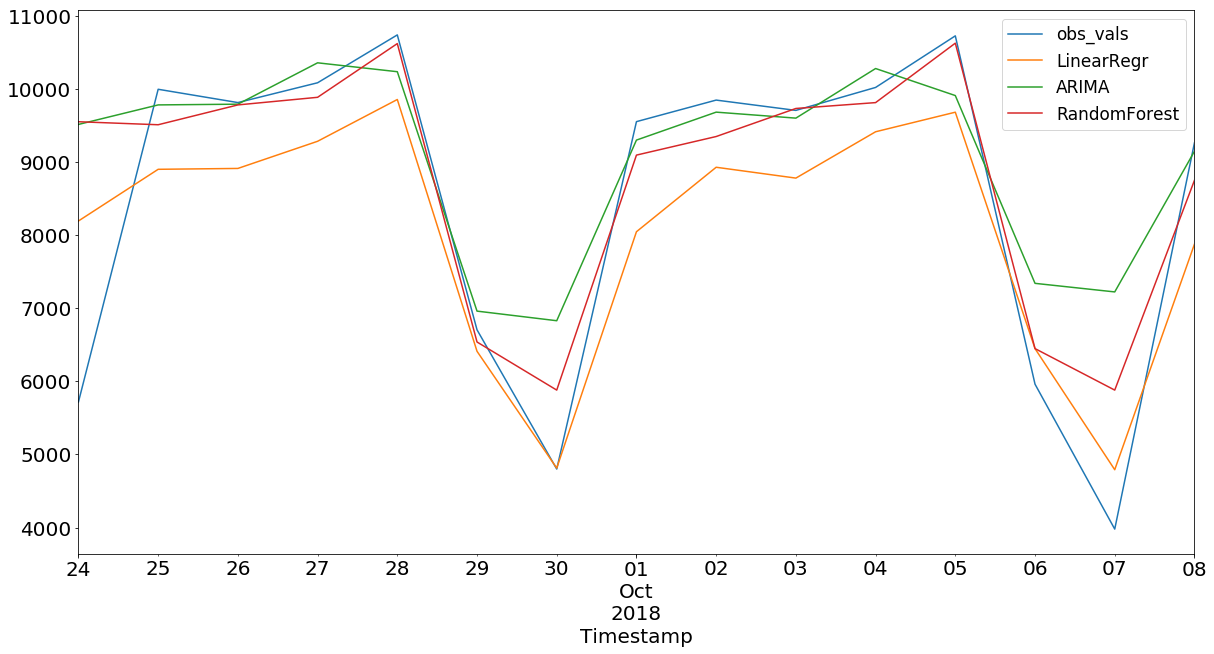

In [5]:
# Plotting the first 15 days of predictions for each model vs. the observations:

ax = models_df[:15].plot(figsize=(20,10), legend=True)
ax.axes.tick_params(labelsize = 20)
ax.axes.tick_params(which='minor', labelsize = 20)
ax.xaxis.label.set_fontsize(20)
ax.legend(loc=1, prop={'size': 17})
plt.show()

In [14]:
#Total RMSE for the total test portion (next 154 days):

get_scoring_measures(models_df, 340, 7, comparing_freqs=True)

,RMSE
LinearRegr,1555.415488
ARIMA,2984.880780
RandomForest,1525.617692


In [15]:
#Total RMSE for the next 15-1 days (discarding day 1, for which all models present big deviations):

get_scoring_measures(models_df[1:15], 340, 7, comparing_freqs=True)

,RMSE
LinearRegr,917.044421
ARIMA,1129.120709
RandomForest,660.930080


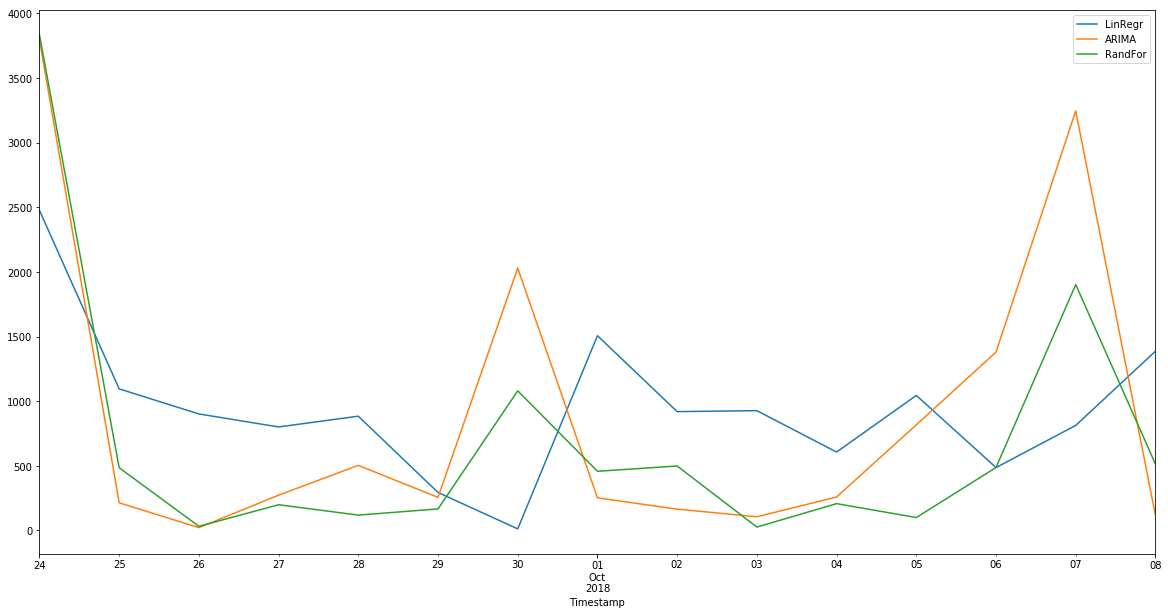

In [16]:
# Plotting the total RMSE for the next 15 days:
RMSE_comparison_df = pd.DataFrame
RMSE_lr = pd.DataFrame 
RMSE_ARIMA = pd.DataFrame
RMSE_rf = pd.DataFrame

for i in range(1,16):
    if RMSE_lr.empty:
        RMSE_lr = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(models_df['obs_vals'][:1], models_df['LinearRegr'][:1])), name = 'LinRegr')) 
        RMSE_ARIMA = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(models_df['obs_vals'][:1], models_df['ARIMA'][:1])), name = 'ARIMA')) 
        RMSE_rf = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(models_df['obs_vals'][:1], models_df['RandomForest'][:1])), name = 'RandFor'))
        
        
    else:
        RMSE_lr = pd.concat([RMSE_lr, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(models_df['obs_vals'][i-1:i], models_df['LinearRegr'][i-1:i])), name = 'LinRegr'))], sort=False)
        RMSE_ARIMA = pd.concat([RMSE_ARIMA, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(models_df['obs_vals'][i-1:i], models_df['ARIMA'][i-1:i])), name = 'ARIMA'))], sort=False)
        RMSE_rf = pd.concat([RMSE_rf, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(models_df['obs_vals'][i-1:i], models_df['RandomForest'][i-1:i])), name = 'RandFor'))], sort=False)
        


RMSE_comparison_df = pd.concat([RMSE_lr, RMSE_ARIMA, RMSE_rf], axis=1)
RMSE_comparison_df.index = models_df[:len(RMSE_lr)].index

ax = RMSE_comparison_df.plot(figsize=(20,10), legend=True)


plt.show()

Random Forest is the algorithm that yields better scorings for the first 15 days (discarding day 1).

## Computing costs

In [28]:
runtime_df = pd.concat([pd.DataFrame(pd.Series(lr_runtime['PUF_allcols_lr_runtime'], name='LinearRegr')), 
                       pd.DataFrame(pd.Series(ARIMA_runtime['daily_PUF_lags_ARIMA_runtime'], name='ARIMA')), 
                       pd.DataFrame(pd.Series(rf_runtime['day_PUF_lags_rf_runtime'], name='RandomForest'))],
                     axis=1)
runtime_df/3600

,LinearRegr,ARIMA,RandomForest
0,2.121187,0.000906,0.018814


The Linear Regression model is by far the most expensive (since it works with high frequency data).

As seen by the results, of the 3 algorithms tested in this project, the model that seems to give better results for the first 15 days of predictions is the Random Forest algorithm. Though the variant chosen for the algorithm has been the one fitted with low frequency data (1 obs. / day), the model fit with high frequency data showed better results for the first 10 days (with the downside of being much more expensive).